# Typhoon Impact Prediction - Option A: Separate Models

This notebook implements separate models for predicting typhoon impact metrics:
- **Regression Models (XGBoostRegressor)** for continuous targets
- **Classification Models (XGBoostClassifier)** for binary targets

## Input Features:
- `max_sustained_wind_kph`: Maximum sustained wind speed in kph
- `typhoon_type`: Type/Category of typhoon
- `max_24hr_rainfall_mm`: Maximum 24-hour rainfall in mm
- `total_storm_rainfall_mm`: Total storm rainfall in mm
- `min_pressure_hpa`: Minimum pressure in hPa

## Output Targets:

### Group A - Regression Targets:
- `families`: Number of affected families
- `person`: Number of affected persons
- `brgy`: Number of affected barangays
- `cost`: Damage cost
- `partially`: Partially damaged structures
- `totally`: Totally damaged structures

### Group B - Classification Targets (Binary: 0 vs 1):
- `dead`: Whether there were deaths (0 = No, 1 = Yes)
- `injured_ill`: Whether there were injured/ill (0 = No, 1 = Yes)
- `missing`: Whether there were missing persons (0 = No, 1 = Yes)

## 1. Import Required Libraries

In [1]:
# Core data manipulation and numerical libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn components
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report
)

# XGBoost for regression and classification
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib
from datetime import datetime
import os

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Define Constants and Configuration

In [2]:
# Define input features
INPUT_FEATURES = [
    'max_sustained_wind_kph',
    'typhoon_type',
    'max_24hr_rainfall_mm',
    'total_storm_rainfall_mm',
    'min_pressure_hpa'
]

# Group A: Regression targets (continuous values)
REGRESSION_TARGETS = [
    'families',
    'person',
    'brgy',
    'cost',
    'partially',
    'totally'
]

# Group B: Classification targets (will be converted to binary 0/1)
CLASSIFICATION_TARGETS = [
    'dead',
    'injured_ill',
    'missing'
]

# Typhoon type encoding (ordinal based on intensity)
TYPHOON_TYPE_MAPPING = {
    'TD': 0,   # Tropical Depression
    'TS': 1,   # Tropical Storm
    'STS': 2,  # Severe Tropical Storm
    'TY': 3,   # Typhoon
    'STY': 4   # Super Typhoon
}

# Random state for reproducibility
RANDOM_STATE = 42

# Test size for train/test split
TEST_SIZE = 0.2

print("Configuration defined successfully!")
print(f"\nInput Features: {INPUT_FEATURES}")
print(f"\nRegression Targets (Group A): {REGRESSION_TARGETS}")
print(f"\nClassification Targets (Group B): {CLASSIFICATION_TARGETS}")

Configuration defined successfully!

Input Features: ['max_sustained_wind_kph', 'typhoon_type', 'max_24hr_rainfall_mm', 'total_storm_rainfall_mm', 'min_pressure_hpa']

Regression Targets (Group A): ['families', 'person', 'brgy', 'cost', 'partially', 'totally']

Classification Targets (Group B): ['dead', 'injured_ill', 'missing']


## 3. Data Loading and Exploration

In [3]:
# Load the dataset
df = pd.read_csv('../data/typhoon_impact_with_extreme_weather.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1776, 30)


,Typhoon Name,Year,Region,Province,City/Municipality,Families,Person,Brgy,Dead,Injured/Ill,...,PAR_END,Duration_in_PAR_Hours,Max_Sustained_Wind_kph,Typhoon_Type,Max_24hr_Rainfall_mm,Total_Storm_Rainfall_mm,Min_Pressure_hPa,Weather_Station_Mapped,Weather_Records_Found,Weather_Days_Covered
0,BETTY,2023,2,BATANES,BASCO,3608,11120,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
1,BETTY,2023,2,BATANES,ITBAYAT,968,3028,5,0,0,...,6/1/2023,133.0,195,STY,20.3,32.71,1000.5,1,6,6
2,BETTY,2023,2,BATANES,IVANA,444,1532,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
3,BETTY,2023,2,BATANES,MAHATAO,575,1792,4,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6
4,BETTY,2023,2,BATANES,SABTANG,575,1955,6,0,0,...,6/1/2023,133.0,195,STY,25.6,39.00,977.1,1,6,6


In [4]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Typhoon Name             1776 non-null   object 
 1   Year                     1776 non-null   int64  
 2   Region                   1776 non-null   int64  
 3   Province                 1776 non-null   object 
 4   City/Municipality        1776 non-null   object 
 5   Families                 1776 non-null   int64  
 6   Person                   1776 non-null   int64  
 7   Brgy                     1776 non-null   int64  
 8   Dead                     1776 non-null   int64  
 9   Injured/Ill              1776 non-null   int64  
 10  Missing                  1776 non-null   int64  
 11  Totally                  1776 non-null   int64  
 12  Partially                1776 non-null   int64  
 13  Total                    1776 non-null   int64  
 14  Quantity                

In [5]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
Typhoon Name               0
Year                       0
Region                     0
Province                   0
City/Municipality          0
Families                   0
Person                     0
Brgy                       0
Dead                       0
Injured/Ill                0
Missing                    0
Totally                    0
Partially                  0
Total                      0
Quantity                   0
Cost                       0
Nearest_Station            0
Station_Province           0
Distance_km                0
PAR_START                  0
PAR_END                    0
Duration_in_PAR_Hours      0
Max_Sustained_Wind_kph     0
Typhoon_Type               0
Max_24hr_Rainfall_mm       0
Total_Storm_Rainfall_mm    0
Min_Pressure_hPa           0
Weather_Station_Mapped     0
Weather_Records_Found      0
Weather_Days_Covered       0
dtype: int64


In [6]:
# Convert column names to lowercase for consistency
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')
print("Columns after normalization:")
print(df.columns.tolist())

Columns after normalization:
['typhoon_name', 'year', 'region', 'province', 'city_municipality', 'families', 'person', 'brgy', 'dead', 'injured_ill', 'missing', 'totally', 'partially', 'total', 'quantity', 'cost', 'nearest_station', 'station_province', 'distance_km', 'par_start', 'par_end', 'duration_in_par_hours', 'max_sustained_wind_kph', 'typhoon_type', 'max_24hr_rainfall_mm', 'total_storm_rainfall_mm', 'min_pressure_hpa', 'weather_station_mapped', 'weather_records_found', 'weather_days_covered']


In [7]:
# Display statistics for all relevant columns
all_targets = REGRESSION_TARGETS + CLASSIFICATION_TARGETS
print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS")
print("="*60)
df[INPUT_FEATURES + all_targets].describe()


DESCRIPTIVE STATISTICS


,max_sustained_wind_kph,max_24hr_rainfall_mm,total_storm_rainfall_mm,min_pressure_hpa,families,person,brgy,cost,partially,totally,dead,injured_ill,missing
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000,1.776000e+03,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000
mean,139.304617,103.854302,168.839127,995.812331,1319.164414,5085.457770,8.808559,3.067556e+05,204.176802,56.121059,0.118243,0.329392,0.005631
std,50.960721,71.202587,111.019046,10.057188,3645.909584,13943.350619,11.442813,1.276232e+06,1029.153384,399.704541,2.617296,2.711094,0.111187
min,45.000000,0.000000,0.000000,924.900000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.000000,50.400000,78.902500,992.200000,16.000000,57.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,120.000000,98.500000,151.200000,998.100000,152.500000,589.500000,4.500000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,195.000000,136.200000,237.200000,1001.800000,969.750000,3639.250000,13.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max,225.000000,510.000000,770.500000,1008.600000,60550.000000,195016.000000,122.000000,1.620751e+07,16719.000000,6588.000000,95.000000,56.000000,4.000000


## 4. Data Preprocessing

In [8]:
# Check unique values of typhoon_type
print("Unique typhoon types:")
print(df['typhoon_type'].unique())
print(f"\nNumber of unique types: {df['typhoon_type'].nunique()}")

Unique typhoon types:
['STY' 'TY' 'STS' 'TD' 'TS']

Number of unique types: 5


In [9]:
# Create a processed copy of the dataframe
df_processed = df.copy()

# Encode typhoon_type using ordinal encoding based on intensity
df_processed['typhoon_type_encoded'] = df_processed['typhoon_type'].map(TYPHOON_TYPE_MAPPING)

print("Typhoon type encoding applied:")
for k, v in TYPHOON_TYPE_MAPPING.items():
    count = (df_processed['typhoon_type'] == k).sum()
    print(f"  {k} -> {v} (n={count})")

# Update input features list to use encoded version
INPUT_FEATURES_ENCODED = [
    'max_sustained_wind_kph',
    'typhoon_type_encoded',
    'max_24hr_rainfall_mm',
    'total_storm_rainfall_mm',
    'min_pressure_hpa'
]

Typhoon type encoding applied:
  TD -> 0 (n=67)
  TS -> 1 (n=234)
  STS -> 2 (n=503)
  TY -> 3 (n=468)
  STY -> 4 (n=504)


In [10]:
# Create binary classification targets
# Convert continuous values to binary: 0 if value == 0, else 1
print("\nCreating binary classification targets:")
print("="*50)

for target in CLASSIFICATION_TARGETS:
    binary_col = f"{target}_binary"
    df_processed[binary_col] = (df_processed[target] > 0).astype(int)
    
    # Display class distribution
    class_counts = df_processed[binary_col].value_counts()
    total = len(df_processed)
    print(f"\n{target}:")
    print(f"  Class 0 (No {target}): {class_counts.get(0, 0)} ({class_counts.get(0, 0)/total*100:.1f}%)")
    print(f"  Class 1 (Has {target}): {class_counts.get(1, 0)} ({class_counts.get(1, 0)/total*100:.1f}%)")


Creating binary classification targets:

dead:
  Class 0 (No dead): 1735 (97.7%)
  Class 1 (Has dead): 41 (2.3%)

injured_ill:
  Class 0 (No injured_ill): 1688 (95.0%)
  Class 1 (Has injured_ill): 88 (5.0%)

missing:
  Class 0 (No missing): 1769 (99.6%)
  Class 1 (Has missing): 7 (0.4%)


In [11]:
# Prepare feature matrix (X)
X = df_processed[INPUT_FEATURES_ENCODED].copy()

# Handle any missing values in features
X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Feature columns: {X.columns.tolist()}")
print("\nFeature statistics:")
X.describe()

Feature matrix shape: (1776, 5)
Feature columns: ['max_sustained_wind_kph', 'typhoon_type_encoded', 'max_24hr_rainfall_mm', 'total_storm_rainfall_mm', 'min_pressure_hpa']

Feature statistics:


,max_sustained_wind_kph,typhoon_type_encoded,max_24hr_rainfall_mm,total_storm_rainfall_mm,min_pressure_hpa
count,1776.000000,1776.000000,1776.000000,1776.000000,1776.000000
mean,139.304617,2.623874,103.854302,168.839127,995.812331
std,50.960721,1.137021,71.202587,111.019046,10.057188
min,45.000000,0.000000,0.000000,0.000000,924.900000
25%,110.000000,2.000000,50.400000,78.902500,992.200000
50%,120.000000,3.000000,98.500000,151.200000,998.100000
75%,195.000000,4.000000,136.200000,237.200000,1001.800000
max,225.000000,4.000000,510.000000,770.500000,1008.600000


In [12]:
# Prepare regression targets (Group A)
y_regression = df_processed[REGRESSION_TARGETS].copy()
y_regression = y_regression.fillna(0)

# Prepare classification targets (Group B) - use binary versions
y_classification = df_processed[[f"{t}_binary" for t in CLASSIFICATION_TARGETS]].copy()

print(f"Regression targets shape: {y_regression.shape}")
print(f"Classification targets shape: {y_classification.shape}")

Regression targets shape: (1776, 6)
Classification targets shape: (1776, 3)


In [13]:
# Split data into training and testing sets
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Split classification targets using same indices
_, _, y_clf_train, y_clf_test = train_test_split(
    X, y_classification, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 1420 samples
Testing set: 356 samples


In [14]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed!")
print("\nScaled training features statistics:")
print(X_train_scaled.describe().round(2))

Feature scaling completed!

Scaled training features statistics:
       max_sustained_wind_kph  typhoon_type_encoded  max_24hr_rainfall_mm  \
count                 1420.00               1420.00               1420.00   
mean                    -0.00                 -0.00                  0.00   
std                      1.00                  1.00                  1.00   
min                     -1.85                 -2.29                 -1.43   
25%                     -0.58                 -0.55                 -0.73   
50%                     -0.38                  0.32                 -0.09   
75%                      1.08                  1.20                  0.43   
max                      1.66                  1.20                  5.70   

       total_storm_rainfall_mm  min_pressure_hpa  
count                  1420.00           1420.00  
mean                      0.00             -0.00  
std                       1.00              1.00  
min                      -1.49       

## 5. Define Reusable Training Functions

In [15]:
def train_regression_model(target, X_train, X_test, y_train, y_test, 
                           plot=True, save_model=True, models_dir='../models'):
    """
    Train an XGBoostRegressor for a single regression target.
    
    Parameters:
    -----------
    target : str
        Name of the target variable
    X_train : pd.DataFrame
        Scaled training features
    X_test : pd.DataFrame
        Scaled testing features
    y_train : pd.Series
        Training target values
    y_test : pd.Series
        Testing target values
    plot : bool
        Whether to plot Actual vs Predicted
    save_model : bool
        Whether to save the trained model
    models_dir : str
        Directory to save models
    
    Returns:
    --------
    dict : Dictionary containing model, predictions, and metrics
    """
    print(f"\n{'='*60}")
    print(f"Training Regression Model: {target}")
    print(f"{'='*60}")
    
    # Initialize XGBoostRegressor
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred_test),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R2': r2_score(y_test, y_pred_test),
        'Train_R2': r2_score(y_train, y_pred_train)
    }
    
    # Print metrics
    print(f"\nMetrics for {target}:")
    print(f"  MAE:      {metrics['MAE']:.4f}")
    print(f"  RMSE:     {metrics['RMSE']:.4f}")
    print(f"  R² Test:  {metrics['R2']:.4f}")
    print(f"  R² Train: {metrics['Train_R2']:.4f}")
    
    # Plot Actual vs Predicted
    if plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(y_test, y_pred_test, alpha=0.5, s=30, edgecolor='white')
        
        # Add perfect prediction line
        min_val = min(y_test.min(), y_pred_test.min())
        max_val = max(y_test.max(), y_pred_test.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        ax.set_xlabel('Actual Values', fontsize=12)
        ax.set_ylabel('Predicted Values', fontsize=12)
        ax.set_title(f'Actual vs Predicted: {target}\nR² = {metrics["R2"]:.4f}', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Save model
    if save_model:
        os.makedirs(models_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = f"{models_dir}/xgb_regressor_{target}_{timestamp}.joblib"
        joblib.dump(model, model_path)
        print(f"  Model saved: {model_path}")
    
    return {
        'model': model,
        'predictions': y_pred_test,
        'metrics': metrics,
        'target': target
    }


print("train_regression_model() function defined successfully!")

train_regression_model() function defined successfully!


In [16]:
def train_classification_model(target, X_train, X_test, y_train, y_test,
                               plot=True, save_model=True, models_dir='../models'):
    """
    Train an XGBoostClassifier for a single binary classification target.
    
    Parameters:
    -----------
    target : str
        Name of the target variable
    X_train : pd.DataFrame
        Scaled training features
    X_test : pd.DataFrame
        Scaled testing features
    y_train : pd.Series
        Training target values (binary 0/1)
    y_test : pd.Series
        Testing target values (binary 0/1)
    plot : bool
        Whether to plot confusion matrix
    save_model : bool
        Whether to save the trained model
    models_dir : str
        Directory to save models
    
    Returns:
    --------
    dict : Dictionary containing model, predictions, and metrics
    """
    print(f"\n{'='*60}")
    print(f"Training Classification Model: {target}")
    print(f"{'='*60}")
    
    # Check class distribution
    class_counts = y_train.value_counts()
    print(f"Training class distribution:")
    print(f"  Class 0: {class_counts.get(0, 0)}")
    print(f"  Class 1: {class_counts.get(1, 0)}")
    
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = class_counts.get(0, 1) / max(class_counts.get(1, 1), 1)
    
    # Initialize XGBoostClassifier
    model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1_Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba) if len(y_test.unique()) > 1 else 0.0
    }
    
    # Print metrics
    print(f"\nMetrics for {target}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  F1-Score: {metrics['F1_Score']:.4f}")
    print(f"  ROC-AUC:  {metrics['ROC_AUC']:.4f}")
    
    # Print classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    if plot:
        fig, ax = plt.subplots(figsize=(6, 5))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        ax.set_xlabel('Predicted', fontsize=12)
        ax.set_ylabel('Actual', fontsize=12)
        ax.set_title(f'Confusion Matrix: {target}\nAccuracy = {metrics["Accuracy"]:.4f}', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    # Save model
    if save_model:
        os.makedirs(models_dir, exist_ok=True)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_path = f"{models_dir}/xgb_classifier_{target}_{timestamp}.joblib"
        joblib.dump(model, model_path)
        print(f"  Model saved: {model_path}")
    
    return {
        'model': model,
        'predictions': y_pred,
        'predictions_proba': y_pred_proba,
        'metrics': metrics,
        'target': target
    }


print("train_classification_model() function defined successfully!")

train_classification_model() function defined successfully!


## 6. Train Regression Models (Group A)

TRAINING REGRESSION MODELS (GROUP A)

Training Regression Model: families

Metrics for families:
  MAE:      1544.3425
  RMSE:     4123.5457
  R² Test:  0.1332
  R² Train: 0.2239


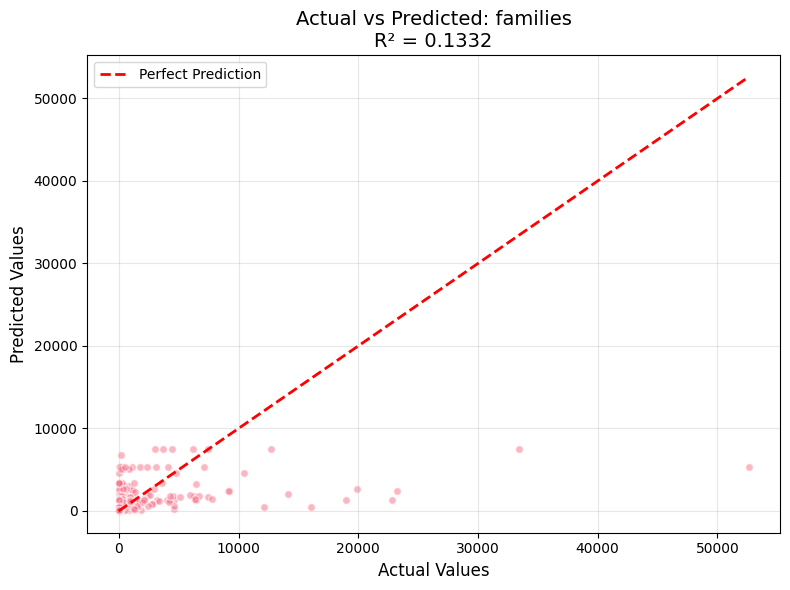

  Model saved: ../models/xgb_regressor_families_20251205_003515.joblib

Training Regression Model: person

Metrics for person:
  MAE:      6096.5204
  RMSE:     16192.7781
  R² Test:  0.1385
  R² Train: 0.2269


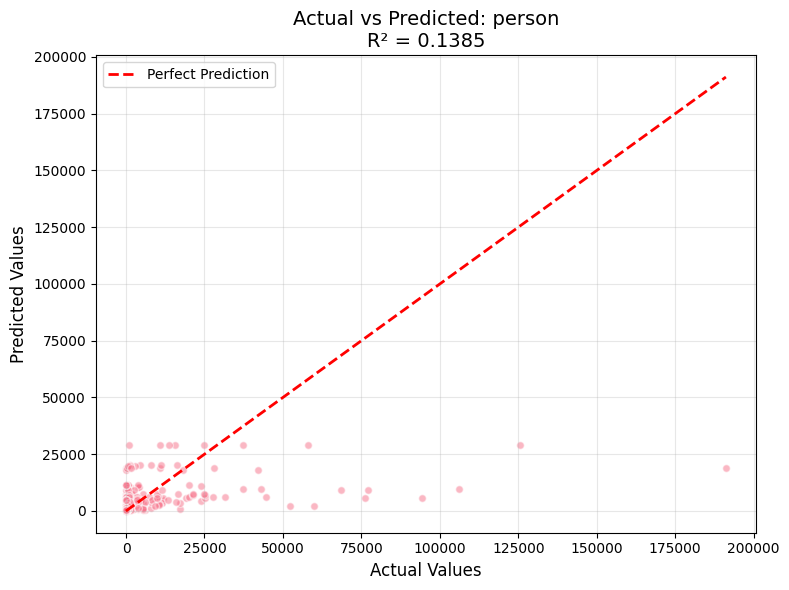

  Model saved: ../models/xgb_regressor_person_20251205_003516.joblib

Training Regression Model: brgy

Metrics for brgy:
  MAE:      6.2964
  RMSE:     10.4605
  R² Test:  0.2529
  R² Train: 0.4099


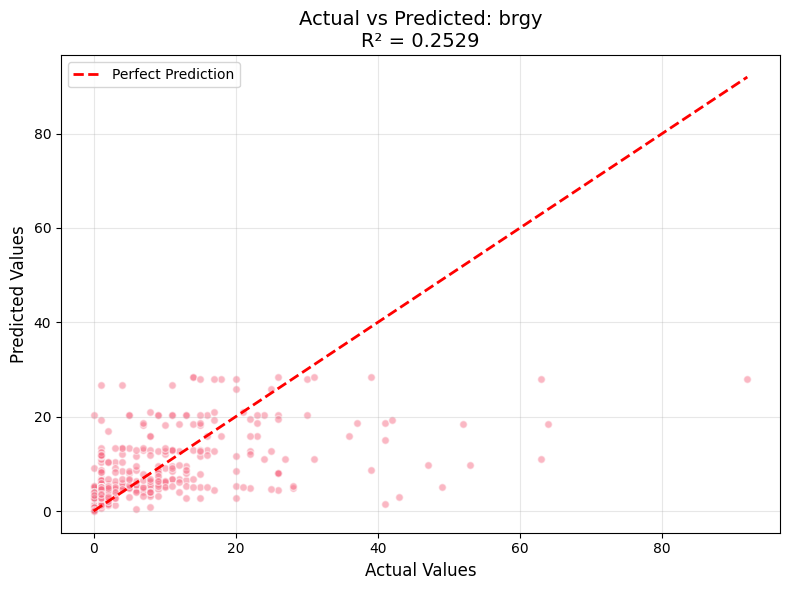

  Model saved: ../models/xgb_regressor_brgy_20251205_003516.joblib

Training Regression Model: cost

Metrics for cost:
  MAE:      327573.5767
  RMSE:     1002188.0265
  R² Test:  0.2645
  R² Train: 0.4226


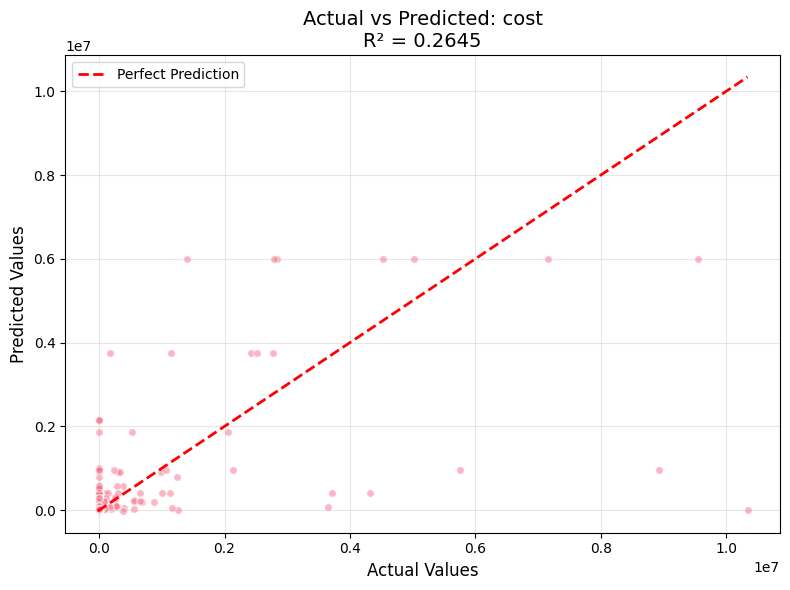

  Model saved: ../models/xgb_regressor_cost_20251205_003516.joblib

Training Regression Model: partially

Metrics for partially:
  MAE:      239.6120
  RMSE:     1017.6398
  R² Test:  0.3861
  R² Train: 0.4316


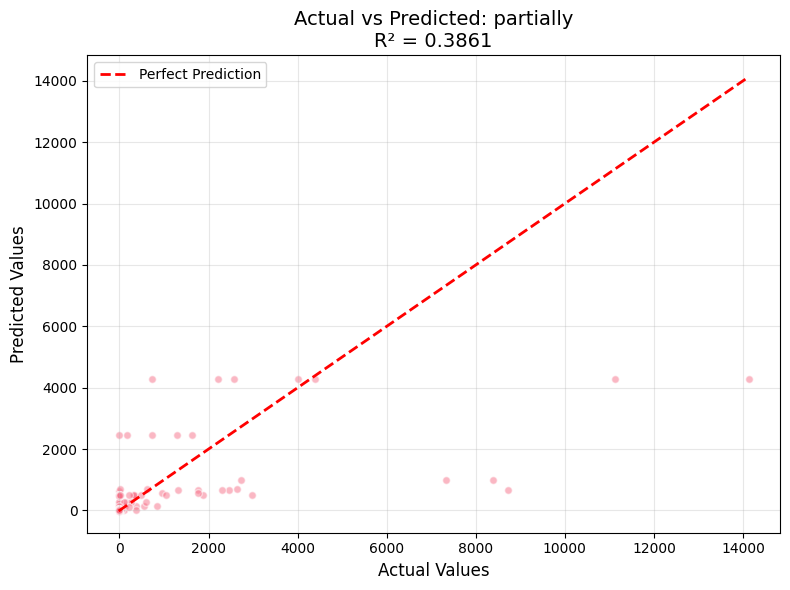

  Model saved: ../models/xgb_regressor_partially_20251205_003517.joblib

Training Regression Model: totally

Metrics for totally:
  MAE:      63.0638
  RMSE:     343.7725
  R² Test:  0.0627
  R² Train: 0.4519


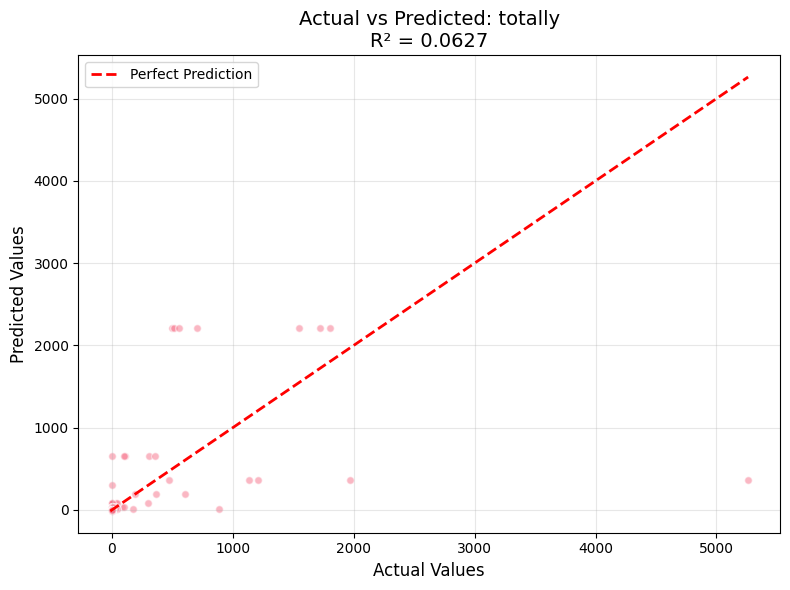

  Model saved: ../models/xgb_regressor_totally_20251205_003517.joblib


In [17]:
# Dictionary to store all regression results
regression_results = {}

print("="*80)
print("TRAINING REGRESSION MODELS (GROUP A)")
print("="*80)

# Train a model for each regression target
for target in REGRESSION_TARGETS:
    result = train_regression_model(
        target=target,
        X_train=X_train_scaled,
        X_test=X_test_scaled,
        y_train=y_reg_train[target],
        y_test=y_reg_test[target],
        plot=True,
        save_model=True
    )
    regression_results[target] = result

## 7. Train Classification Models (Group B)

TRAINING CLASSIFICATION MODELS (GROUP B)

Training Classification Model: dead
Training class distribution:
  Class 0: 1389
  Class 1: 31

Metrics for dead:
  Accuracy: 0.8287
  F1-Score: 0.1408
  ROC-AUC:  0.7168

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       346
           1       0.08      0.50      0.14        10

    accuracy                           0.83       356
   macro avg       0.53      0.67      0.52       356
weighted avg       0.96      0.83      0.88       356



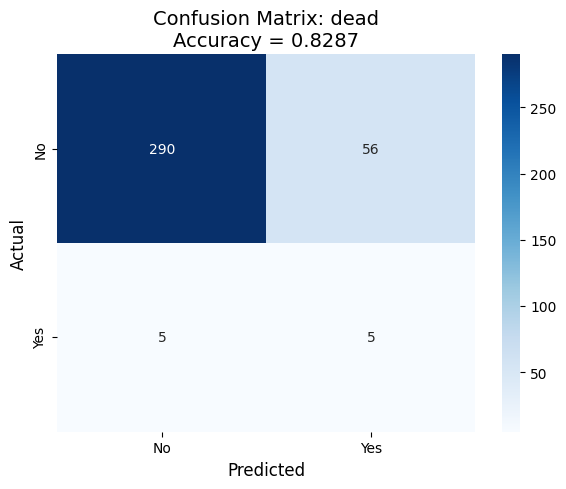

  Model saved: ../models/xgb_classifier_dead_20251205_003518.joblib

Training Classification Model: injured_ill
Training class distribution:
  Class 0: 1351
  Class 1: 69

Metrics for injured_ill:
  Accuracy: 0.7949
  F1-Score: 0.2474
  ROC-AUC:  0.8135

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       337
           1       0.15      0.63      0.25        19

    accuracy                           0.79       356
   macro avg       0.56      0.72      0.56       356
weighted avg       0.93      0.79      0.85       356



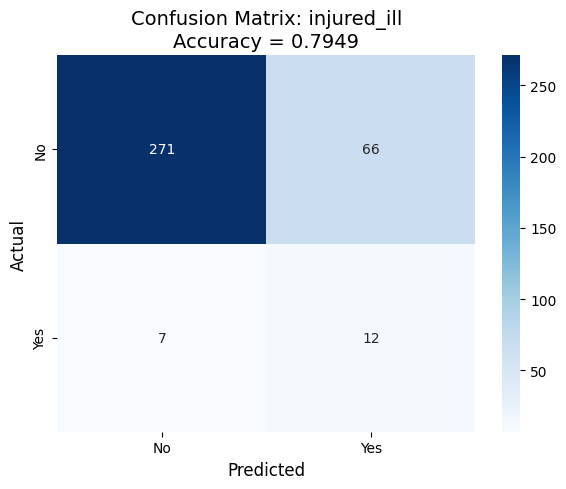

  Model saved: ../models/xgb_classifier_injured_ill_20251205_003519.joblib

Training Classification Model: missing
Training class distribution:
  Class 0: 1417
  Class 1: 3

Metrics for missing:
  Accuracy: 0.9522
  F1-Score: 0.0000
  ROC-AUC:  0.1818

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       352
           1       0.00      0.00      0.00         4

    accuracy                           0.95       356
   macro avg       0.49      0.48      0.49       356
weighted avg       0.98      0.95      0.96       356



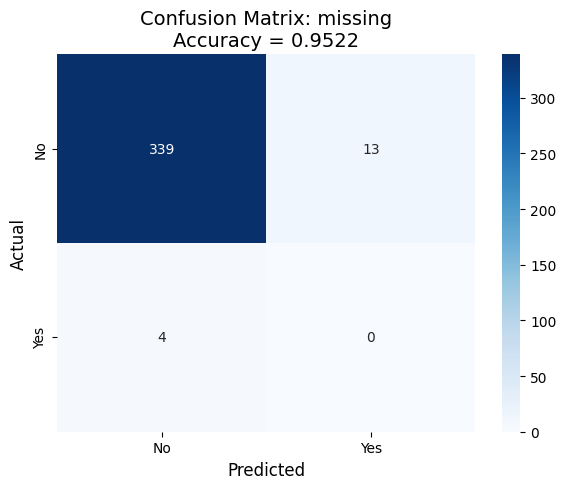

  Model saved: ../models/xgb_classifier_missing_20251205_003519.joblib


In [18]:
# Dictionary to store all classification results
classification_results = {}

print("="*80)
print("TRAINING CLASSIFICATION MODELS (GROUP B)")
print("="*80)

# Train a model for each classification target
for target in CLASSIFICATION_TARGETS:
    binary_col = f"{target}_binary"
    result = train_classification_model(
        target=target,
        X_train=X_train_scaled,
        X_test=X_test_scaled,
        y_train=y_clf_train[binary_col],
        y_test=y_clf_test[binary_col],
        plot=True,
        save_model=True
    )
    classification_results[target] = result

## 8. Model Performance Summary

In [19]:
# Create summary table for regression models
print("="*80)
print("REGRESSION MODELS SUMMARY (GROUP A)")
print("="*80)

regression_summary = []
for target, result in regression_results.items():
    regression_summary.append({
        'Target': target,
        'MAE': result['metrics']['MAE'],
        'RMSE': result['metrics']['RMSE'],
        'R² (Test)': result['metrics']['R2'],
        'R² (Train)': result['metrics']['Train_R2']
    })

regression_summary_df = pd.DataFrame(regression_summary)
print("\n")
display(regression_summary_df.round(4))

REGRESSION MODELS SUMMARY (GROUP A)




,Target,MAE,RMSE,R² (Test),R² (Train)
0,families,1544.3425,4.123546e+03,0.1332,0.2239
1,person,6096.5204,1.619278e+04,0.1385,0.2269
2,brgy,6.2964,1.046050e+01,0.2529,0.4099
3,cost,327573.5767,1.002188e+06,0.2645,0.4226
4,partially,239.6120,1.017640e+03,0.3861,0.4316
5,totally,63.0638,3.437725e+02,0.0627,0.4519


In [20]:
# Create summary table for classification models
print("="*80)
print("CLASSIFICATION MODELS SUMMARY (GROUP B)")
print("="*80)

classification_summary = []
for target, result in classification_results.items():
    classification_summary.append({
        'Target': target,
        'Accuracy': result['metrics']['Accuracy'],
        'F1-Score': result['metrics']['F1_Score'],
        'ROC-AUC': result['metrics']['ROC_AUC']
    })

classification_summary_df = pd.DataFrame(classification_summary)
print("\n")
display(classification_summary_df.round(4))

CLASSIFICATION MODELS SUMMARY (GROUP B)




,Target,Accuracy,F1-Score,ROC-AUC
0,dead,0.8287,0.1408,0.7168
1,injured_ill,0.7949,0.2474,0.8135
2,missing,0.9522,0.0000,0.1818


In [21]:
# Combined summary table for all 9 targets
print("="*80)
print("COMPLETE MODEL PERFORMANCE SUMMARY (ALL 9 TARGETS)")
print("="*80)

complete_summary = []

# Add regression targets
for target, result in regression_results.items():
    complete_summary.append({
        'Target': target,
        'Model Type': 'Regression',
        'Primary Metric': 'R²',
        'Score': result['metrics']['R2'],
        'Secondary Metric': 'RMSE',
        'Secondary Score': result['metrics']['RMSE']
    })

# Add classification targets
for target, result in classification_results.items():
    complete_summary.append({
        'Target': target,
        'Model Type': 'Classification',
        'Primary Metric': 'ROC-AUC',
        'Score': result['metrics']['ROC_AUC'],
        'Secondary Metric': 'F1-Score',
        'Secondary Score': result['metrics']['F1_Score']
    })

complete_summary_df = pd.DataFrame(complete_summary)
print("\n")
display(complete_summary_df.round(4))

COMPLETE MODEL PERFORMANCE SUMMARY (ALL 9 TARGETS)




,Target,Model Type,Primary Metric,Score,Secondary Metric,Secondary Score
0,families,Regression,R²,0.1332,RMSE,4.123546e+03
1,person,Regression,R²,0.1385,RMSE,1.619278e+04
2,brgy,Regression,R²,0.2529,RMSE,1.046050e+01
3,cost,Regression,R²,0.2645,RMSE,1.002188e+06
4,partially,Regression,R²,0.3861,RMSE,1.017640e+03
5,totally,Regression,R²,0.0627,RMSE,3.437725e+02
6,dead,Classification,ROC-AUC,0.7168,F1-Score,1.408000e-01
7,injured_ill,Classification,ROC-AUC,0.8135,F1-Score,2.474000e-01
8,missing,Classification,ROC-AUC,0.1818,F1-Score,0.000000e+00


## 9. Visualize Model Performance Comparison

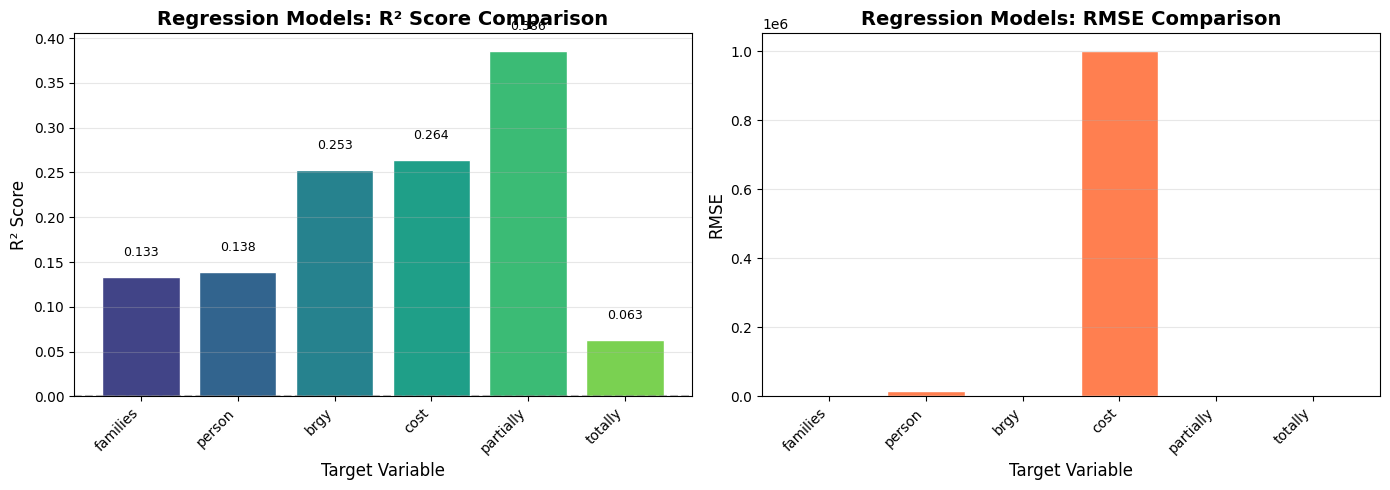

In [22]:
# Visualize regression model performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² scores
ax1 = axes[0]
targets = regression_summary_df['Target']
r2_scores = regression_summary_df['R² (Test)']
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(targets)))

bars1 = ax1.bar(targets, r2_scores, color=colors, edgecolor='white')
ax1.set_xlabel('Target Variable', fontsize=12)
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('Regression Models: R² Score Comparison', fontsize=14, fontweight='bold')
ax1.set_xticklabels(targets, rotation=45, ha='right')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars1, r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# RMSE scores
ax2 = axes[1]
rmse_scores = regression_summary_df['RMSE']

bars2 = ax2.bar(targets, rmse_scores, color='coral', edgecolor='white')
ax2.set_xlabel('Target Variable', fontsize=12)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('Regression Models: RMSE Comparison', fontsize=14, fontweight='bold')
ax2.set_xticklabels(targets, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

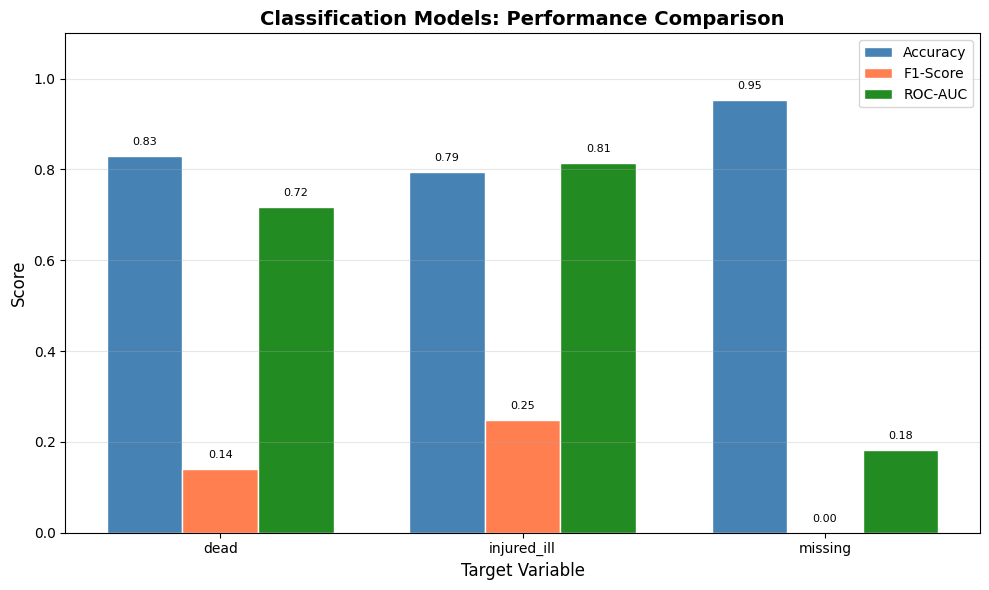

In [23]:
# Visualize classification model performance
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(CLASSIFICATION_TARGETS))
width = 0.25

accuracy = classification_summary_df['Accuracy']
f1 = classification_summary_df['F1-Score']
roc_auc = classification_summary_df['ROC-AUC']

bars1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='steelblue', edgecolor='white')
bars2 = ax.bar(x, f1, width, label='F1-Score', color='coral', edgecolor='white')
bars3 = ax.bar(x + width, roc_auc, width, label='ROC-AUC', color='forestgreen', edgecolor='white')

ax.set_xlabel('Target Variable', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Classification Models: Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASSIFICATION_TARGETS)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 10. Feature Importance Analysis

In [24]:
# Get average feature importance across all regression models
print("="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Calculate average importance
all_importance = []
for target, result in regression_results.items():
    importance = result['model'].feature_importances_
    all_importance.append(importance)

avg_importance = np.mean(all_importance, axis=0)

# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': INPUT_FEATURES_ENCODED,
    'Avg_Importance': avg_importance
}).sort_values('Avg_Importance', ascending=False)

print("\nAverage Feature Importance (Regression Models):")
print(importance_df.to_string(index=False))

FEATURE IMPORTANCE ANALYSIS

Average Feature Importance (Regression Models):
                Feature  Avg_Importance
       min_pressure_hpa        0.442522
   max_24hr_rainfall_mm        0.189588
total_storm_rainfall_mm        0.146624
 max_sustained_wind_kph        0.136193
   typhoon_type_encoded        0.085073


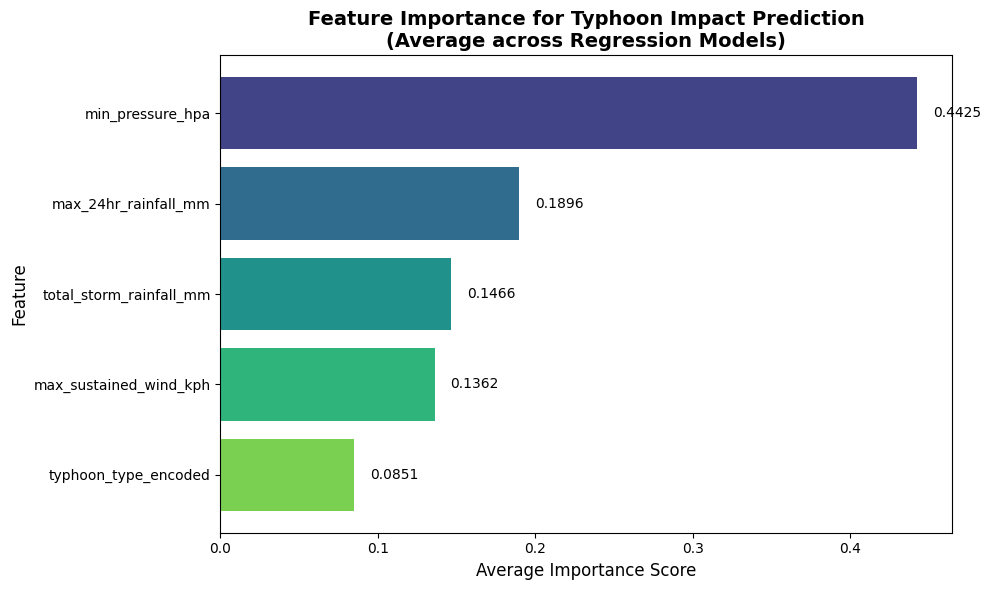

In [25]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(importance_df)))
bars = ax.barh(importance_df['Feature'], importance_df['Avg_Importance'], color=colors)

ax.set_xlabel('Average Importance Score', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Feature Importance for Typhoon Impact Prediction\n(Average across Regression Models)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, importance in zip(bars, importance_df['Avg_Importance']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

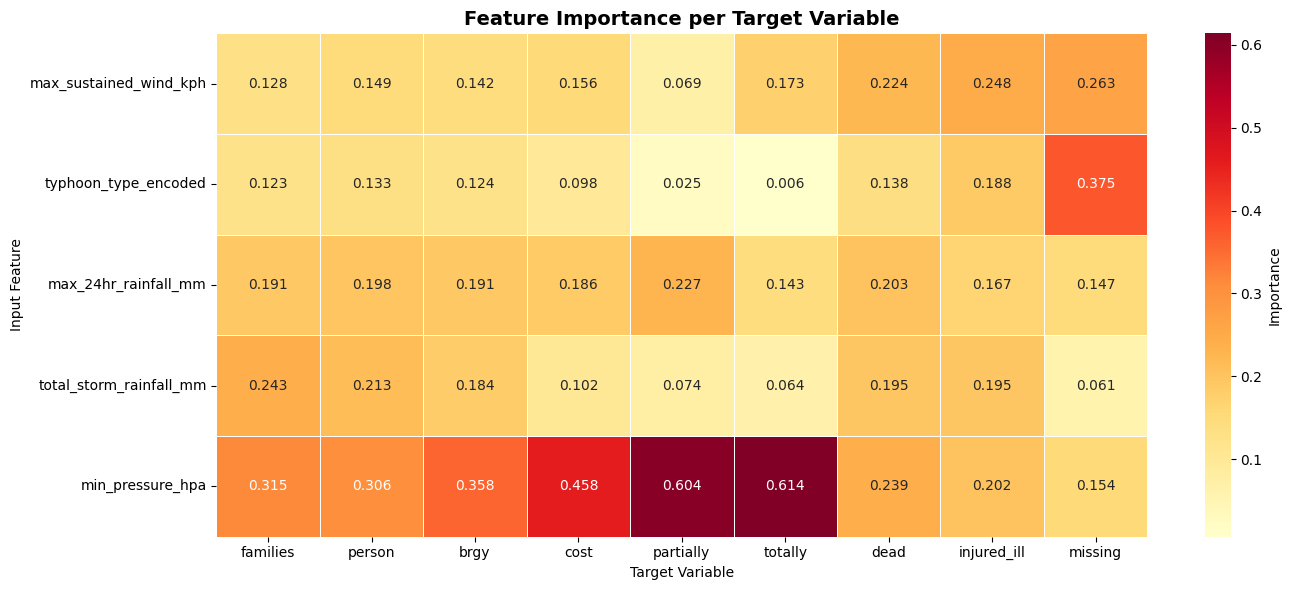

In [26]:
# Feature importance heatmap per target
importance_per_target = {}

# Regression targets
for target, result in regression_results.items():
    importance_per_target[target] = result['model'].feature_importances_

# Classification targets
for target, result in classification_results.items():
    importance_per_target[target] = result['model'].feature_importances_

importance_matrix = pd.DataFrame(importance_per_target, index=INPUT_FEATURES_ENCODED)

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(importance_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Importance'})
plt.title('Feature Importance per Target Variable', fontsize=14, fontweight='bold')
plt.xlabel('Target Variable')
plt.ylabel('Input Feature')
plt.tight_layout()
plt.show()

## 11. Save Models and Results

In [27]:
# Save scaler
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

scaler_path = f"{models_dir}/feature_scaler_{timestamp}.joblib"
joblib.dump(scaler, scaler_path)
print(f"Feature scaler saved: {scaler_path}")

# Save configuration
config = {
    'input_features': INPUT_FEATURES_ENCODED,
    'regression_targets': REGRESSION_TARGETS,
    'classification_targets': CLASSIFICATION_TARGETS,
    'typhoon_type_mapping': TYPHOON_TYPE_MAPPING,
    'timestamp': timestamp
}
config_path = f"{models_dir}/model_config_{timestamp}.joblib"
joblib.dump(config, config_path)
print(f"Model configuration saved: {config_path}")

Feature scaler saved: ../models/feature_scaler_20251205_003524.joblib
Model configuration saved: ../models/model_config_20251205_003524.joblib


In [28]:
# Save complete results summary to CSV
complete_summary_df.to_csv(f'{models_dir}/model_performance_summary_{timestamp}.csv', index=False)
print(f"Performance summary saved: model_performance_summary_{timestamp}.csv")

# Save detailed regression results
regression_summary_df.to_csv(f'{models_dir}/regression_results_{timestamp}.csv', index=False)
print(f"Regression results saved: regression_results_{timestamp}.csv")

# Save detailed classification results
classification_summary_df.to_csv(f'{models_dir}/classification_results_{timestamp}.csv', index=False)
print(f"Classification results saved: classification_results_{timestamp}.csv")

Performance summary saved: model_performance_summary_20251205_003524.csv
Regression results saved: regression_results_20251205_003524.csv
Classification results saved: classification_results_20251205_003524.csv


## 12. Sample Predictions

In [29]:
# Make sample predictions
print("="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Select a few test samples
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), size=3, replace=False)

for idx in sample_indices:
    print(f"\n{'='*60}")
    print(f"Sample Index: {idx}")
    print(f"{'='*60}")
    
    print("\nInput Features:")
    for col in INPUT_FEATURES_ENCODED:
        print(f"  {col}: {X_test.iloc[idx][col]:.2f}")
    
    print("\n--- Regression Predictions ---")
    print(f"{'Target':<15} {'Actual':>12} {'Predicted':>12} {'Error':>12}")
    print("-"*55)
    for target in REGRESSION_TARGETS:
        actual = y_reg_test[target].iloc[idx]
        pred_idx = list(X_test.index).index(X_test.index[idx])
        predicted = regression_results[target]['predictions'][pred_idx]
        error = actual - predicted
        print(f"{target:<15} {actual:>12.2f} {predicted:>12.2f} {error:>12.2f}")
    
    print("\n--- Classification Predictions ---")
    print(f"{'Target':<15} {'Actual':>12} {'Predicted':>12} {'Prob(1)':>12}")
    print("-"*55)
    for target in CLASSIFICATION_TARGETS:
        binary_col = f"{target}_binary"
        actual = y_clf_test[binary_col].iloc[idx]
        pred_idx = list(X_test.index).index(X_test.index[idx])
        predicted = classification_results[target]['predictions'][pred_idx]
        prob = classification_results[target]['predictions_proba'][pred_idx]
        actual_label = 'Yes' if actual == 1 else 'No'
        pred_label = 'Yes' if predicted == 1 else 'No'
        print(f"{target:<15} {actual_label:>12} {pred_label:>12} {prob:>12.4f}")

SAMPLE PREDICTIONS

Sample Index: 227

Input Features:
  max_sustained_wind_kph: 225.00
  typhoon_type_encoded: 4.00
  max_24hr_rainfall_mm: 166.70
  total_storm_rainfall_mm: 287.90
  min_pressure_hpa: 981.00

--- Regression Predictions ---
Target                Actual    Predicted        Error
-------------------------------------------------------
families              269.00      5365.37     -5096.37
person               1160.00     20096.56    -18936.56
brgy                   14.00        28.46       -14.46
cost                    0.00    912689.25   -912689.25
partially             169.00      2451.17     -2282.17
totally               100.00       659.97      -559.97

--- Classification Predictions ---
Target                Actual    Predicted      Prob(1)
-------------------------------------------------------
dead                      No           No       0.0002
injured_ill               No           No       0.0037
missing                   No           No       0.0007

Sampl

## 13. Final Summary

In [30]:
# Print final summary
print("="*80)
print("OPTION A: SEPARATE MODELS - FINAL SUMMARY")
print("="*80)

print("\n1. DATASET INFORMATION")
print(f"   - Total samples: {len(df)}")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Testing samples: {len(X_test)}")
print(f"   - Input features: {len(INPUT_FEATURES_ENCODED)}")

print("\n2. INPUT FEATURES")
for feat in INPUT_FEATURES_ENCODED:
    print(f"   - {feat}")

print("\n3. GROUP A - REGRESSION TARGETS (XGBoostRegressor)")
for target in REGRESSION_TARGETS:
    r2 = regression_results[target]['metrics']['R2']
    print(f"   - {target}: R² = {r2:.4f}")

print("\n4. GROUP B - CLASSIFICATION TARGETS (XGBoostClassifier)")
for target in CLASSIFICATION_TARGETS:
    auc = classification_results[target]['metrics']['ROC_AUC']
    print(f"   - {target}: ROC-AUC = {auc:.4f}")

print("\n5. OVERALL PERFORMANCE")
avg_r2 = np.mean([r['metrics']['R2'] for r in regression_results.values()])
avg_auc = np.mean([r['metrics']['ROC_AUC'] for r in classification_results.values()])
print(f"   - Average R² (Regression): {avg_r2:.4f}")
print(f"   - Average ROC-AUC (Classification): {avg_auc:.4f}")

print("\n6. TOP CONTRIBUTING FEATURES")
for _, row in importance_df.head(3).iterrows():
    print(f"   - {row['Feature']}: {row['Avg_Importance']:.4f}")

print("\n7. SAVED ARTIFACTS")
print(f"   - Feature scaler: feature_scaler_{timestamp}.joblib")
print(f"   - Model configuration: model_config_{timestamp}.joblib")
print(f"   - 6 Regression models (XGBRegressor)")
print(f"   - 3 Classification models (XGBClassifier)")
print(f"   - Performance summaries (CSV)")

print("\n" + "="*80)
print("END OF OPTION A: SEPARATE MODELS ANALYSIS")
print("="*80)

OPTION A: SEPARATE MODELS - FINAL SUMMARY

1. DATASET INFORMATION
   - Total samples: 1776
   - Training samples: 1420
   - Testing samples: 356
   - Input features: 5

2. INPUT FEATURES
   - max_sustained_wind_kph
   - typhoon_type_encoded
   - max_24hr_rainfall_mm
   - total_storm_rainfall_mm
   - min_pressure_hpa

3. GROUP A - REGRESSION TARGETS (XGBoostRegressor)
   - families: R² = 0.1332
   - person: R² = 0.1385
   - brgy: R² = 0.2529
   - cost: R² = 0.2645
   - partially: R² = 0.3861
   - totally: R² = 0.0627

4. GROUP B - CLASSIFICATION TARGETS (XGBoostClassifier)
   - dead: ROC-AUC = 0.7168
   - injured_ill: ROC-AUC = 0.8135
   - missing: ROC-AUC = 0.1818

5. OVERALL PERFORMANCE
   - Average R² (Regression): 0.2063
   - Average ROC-AUC (Classification): 0.5707

6. TOP CONTRIBUTING FEATURES
   - min_pressure_hpa: 0.4425
   - max_24hr_rainfall_mm: 0.1896
   - total_storm_rainfall_mm: 0.1466

7. SAVED ARTIFACTS
   - Feature scaler: feature_scaler_20251205_003524.joblib
   - Model